In [21]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from utils import *
import scipy
from scipy import ndimage
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Define the model

In [34]:
def model(X, Y, layer_dims, num_iterations=2000, learning_rate=0.01, printCost=False):
    
    #Initialize Parameters
    parameters = initialize_parameters(layer_dims)
    costs = []
    
    #Start Learning
    for i in range(num_iterations):
        
        #Forward Propagate
        AL, cache = forwardPropagation(X, parameters)
        
        #Find Cost
        cost = computeCost(AL, Y)
        if printCost and i%100==0:
            print("Cost at iteration " + str(i) + " is " + str(cost))
            costs.append(cost)
        
        #Back Propagate
        grads = backPropagation(AL, Y, cache)
        
        #Update Parameters
        parameters = updateParameters(parameters, grads, learning_rate)
    
    #plot cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('number of iterations')
    plt.title('Learning Rate: ' + str(learning_rate))
    plt.show()
    
    return parameters


def predict(X, Y, final_parameters):
    probabs, cache = forwardPropagation(X, final_parameters)
    m = X.shape[1]
    p = np.zeros((1, m), dtype=float)
    for i in range(probabs.shape[1]):
        if probabs[0, i] >= 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
    print("Accuracy: " + str(np.sum((p == Y)/m)))
    return p

# Train the Model

Cost at iteration 0 is 0.6945717739730115
Cost at iteration 100 is 0.6434061703489665
Cost at iteration 200 is 0.6166101894849434
Cost at iteration 300 is 0.5627617707103282
Cost at iteration 400 is 0.5057347612191672
Cost at iteration 500 is 0.4536798494989342
Cost at iteration 600 is 0.44134490509522084
Cost at iteration 700 is 0.4088202976924792
Cost at iteration 800 is 0.3798669429657168
Cost at iteration 900 is 0.35324452384840277
Cost at iteration 1000 is 0.32647772660402136
Cost at iteration 1100 is 0.3251916886386944
Cost at iteration 1200 is 0.19761115804713694
Cost at iteration 1300 is 0.2943145151582862
Cost at iteration 1400 is 0.3976809043528349
Cost at iteration 1500 is 0.5780736011230613
Cost at iteration 1600 is 0.09105038204553033
Cost at iteration 1700 is 0.09918425427744583
Cost at iteration 1800 is 0.06764502339574621
Cost at iteration 1900 is 0.05592438041650194
Cost at iteration 2000 is 0.04720512452580236
Cost at iteration 2100 is 0.04038995342170164
Cost at iter

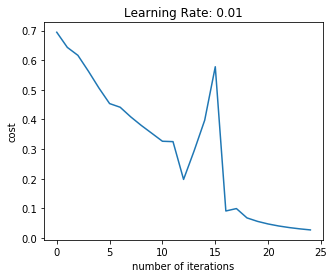

Accuracy: 1.0
Accuracy: 0.72


In [38]:
#Load training data
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

#Flatten and Normalize
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

#Perform the training
# layer_dims = [12288, 20, 7, 5, 1]
layer_dims = [12288, 7, 1]
parameters = model(train_x, train_y, layer_dims, 2500, 0.01, True)

#Test the model
pred_train = predict(train_x, train_y, parameters)
pred_test = predict(test_x, test_y, parameters)

# Supporting Functions

In [23]:
def initialize_parameters(dims):
    parameters = {}
    L = len(dims)
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(dims[l], dims[l-1]) * 0.01
        parameters["b" + str(l)] = np.zeros((dims[l], 1), dtype=float)
    return parameters

In [30]:
def forwardPropagation(X, parameters):
    L = len(parameters)//2
    A = X
    caches = []
    for l in range(1, L):
        A_prev = A
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        A,cache = linear_activation_forward(A_prev, W, b, "relu")
        caches.append(cache)
    
    #For final layer
    W = parameters["W" + str(L)]
    b = parameters["b" + str(L)]
    AL,cache = linear_activation_forward(A, W, b, "sigmoid")
    caches.append(cache)
    
    return AL, caches

def linear_activation_forward(A_prev, W, b, activation):
    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation=="relu":
        A, activation_cache = relu(Z)
    else:
        A, activation_cache = sigmoid(Z)
    cache = (linear_cache, activation_cache)
    return A, cache
    
def linear_forward(A_prev, W, b):
    Z = np.dot(W, A_prev) + b
    cache = (A_prev, W, b)
    return Z, cache

def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

In [36]:
def computeCost(AL, Y):
    m = Y.shape[1]
    cost = (-1/m) * ((np.dot(Y, np.log(AL.T))) + (np.dot(1-Y, np.log(1-AL.T))))
    cost = np.squeeze(cost)
    return cost

In [26]:
def backPropagation(AL, Y, caches):
    grads = {}
    L = len(caches)
    
    #for final layer
    grads["dA" + str(L)] = -(np.divide(Y, AL)) + np.divide(1-Y, 1-AL)
    current_cache = caches[L - 1]
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backwards(grads["dA" + str(L)], current_cache, "sigmoid")
    
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = linear_activation_backwards(grads["dA" + str(l + 1)], current_cache, "relu")
        
    return grads

def linear_activation_backwards(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backwards(dA, activation_cache)
    else:
        dZ = sigmoid_backwards(dA, activation_cache)
    
    dA_prev, dW, db = linear_backwards(dZ, linear_cache)
    return dA_prev, dW, db

    
def linear_backwards(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis = 1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db
    

def relu_backwards(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z<=0] = 0
    return dZ

def sigmoid_backwards(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

In [27]:
def updateParameters(parameters, grads, learning_rate):
    L = len(parameters)//2
    for l in range(L):
        parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
    return parameters